# Forecast

In [183]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [184]:
import sys
import os

# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor

Đã thêm đường dẫn gốc: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


1) Dự báo điểm theo môn

In [185]:
# Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")



=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu


In [186]:
# Load cleaned data: 
clean_data = CleanDataLoader() 

In [187]:
# Lấy dữ liệu phân phối và phân tích cho từng môn học
dist_list = []
analysis_list = []

for choice, subject in subject_map.items():

    # ----- DISTRIBUTION -----
    df_dist = clean_data.get_subject_data(
        subject=subject,
        kind="distribution"
    )

    if df_dist is not None and not df_dist.empty:

        # Chuẩn hoá cột môn học
        if "mon_hoc" in df_dist.columns:
            df_dist = df_dist.rename(columns={"mon_hoc": "subject"})
        else:
            df_dist["subject"] = subject

        # Phòng trường hợp vẫn còn 2 cột
        df_dist = df_dist.loc[:, ~df_dist.columns.duplicated()]

        dist_list.append(df_dist)

    # ----- ANALYSIS -----
    df_anal = clean_data.get_subject_data(
        subject=subject,
        kind="analysis"
    )

    if df_anal is not None and not df_anal.empty:

        if "mon_hoc" in df_anal.columns:
            df_anal = df_anal.rename(columns={"mon_hoc": "subject"})
        else:
            df_anal["subject"] = subject

        df_anal = df_anal.loc[:, ~df_anal.columns.duplicated()]

        analysis_list.append(df_anal)

# ----- CONCAT -----
df_distribution = pd.concat(dist_list, ignore_index=True)
df_analysis = pd.concat(analysis_list, ignore_index=True)

print(df_distribution.head() ,"\n")
print(df_analysis.head())

   nam_hoc subject  diem  so_hoc_sinh
0     2023    toan   0.0            2
1     2023    toan   0.2            1
2     2023    toan   0.4            2
3     2023    toan   0.6            4
4     2023    toan   0.8           32 

   nam_hoc      mean  median  mode       std  min   max  subject
0     2023  6.250557     6.6  7.60  1.633336  0.0  10.0     toan
1     2024  6.447309     6.8  7.60  1.556900  0.0   9.8     toan
2     2025  4.799712     4.6  4.75  1.688549  0.0  10.0     toan
3     2023  6.858194     7.0  7.00  1.326471  0.0  10.0  ngu_van
4     2024  7.231146     7.5  8.00  1.330057  0.0  10.0  ngu_van


In [188]:
n_students_df = (
    df_distribution
    .groupby("nam_hoc")["so_hoc_sinh"]
    .sum()
    .reset_index(name="n_students")
) # Tổng số học sinh theo năm học

summary_df = df_analysis.merge(
    n_students_df,
    on="nam_hoc",
    how="left"
) # Tạo dataframe tổng hợp với số học sinh

summary_df_std = summary_df.copy()
summary_df_std = summary_df_std.rename(columns={
    "nam_hoc": "year",
    "mean": "mean_score",
    "median": "median_score"
}) # Chuẩn hoá tên cột

summary_df_std = summary_df_std[
    ["year", "subject", "mean_score", "median_score", "std", "n_students"]
] # Chuẩn hoá dataframe

print(summary_df_std.head())

   year  subject  mean_score  median_score       std  n_students
0  2023     toan    6.250557           6.6  1.633336     5803574
1  2024     toan    6.447309           6.8  1.556900     6037435
2  2025     toan    4.799712           4.6  1.688549     4579308
3  2023  ngu_van    6.858194           7.0  1.326471     5803574
4  2024  ngu_van    7.231146           7.5  1.330057     6037435


In [189]:
# Xây dựng series_dict cho mô hình ARIMAX với biến giả break tại 2025
df = summary_df_std.copy()
df["post_2025"] = (df["year"] >= 2025).astype(int)

df = df.sort_values(["subject", "year"])

series_dict = {}

for subject, g in df.groupby("subject"):
    g = g.sort_values("year")
    
    y = g.set_index("year")["mean_score"]
    exog = g.set_index("year")[["post_2025"]]
    
    series_dict[subject] = {
        "y": y,
        "exog": exog
    }

In [ ]:
# Hàm xây dựng dataframe dựa trên feature cho mô hình RF và XGB
def build_ml_df(df, df_rates=None):
    df = df.sort_values(["subject", "year"]).copy()

    df["post_2025"] = (df["year"] >= 2025).astype(int)

    df["delta_score"] = (
        df.groupby("subject")["mean_score"]
          .diff()
          .fillna(0)
    )

    df["mean_prev"] = (
        df.groupby("subject")["mean_score"]
          .transform(lambda x: x.shift().expanding().mean())
    )

    df["is_first_year"] = (df.groupby("subject").cumcount() == 0).astype(int)

    df["mean_prev"] = (
        df["mean_prev"]
        .fillna(0)
    )

    # ===== merge tỉ lệ nếu có =====
    if df_rates is not None:
        df = df.merge(df_rates, on=["year", "subject"], how="left")
        df[["rate_ge_5", "rate_ge_8"]] = df[["rate_ge_5", "rate_ge_8"]].fillna(0)

    return df

In [191]:
# 1. Chuẩn hóa distribution dataframe
df_dist_std = df_distribution.rename(columns={
    "nam_hoc": "year",
    "diem": "score",
    "so_hoc_sinh": "count"
})

# 2. Tổng số thí sinh
total_students = (
    df_dist_std
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_students"})
)

# 3. Số thí sinh ≥ 5
ge_5 = (
    df_dist_std[df_dist_std["score"] >= 5]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_5"})
)

# 4. Số thí sinh ≥ 8
ge_8 = (
    df_dist_std[df_dist_std["score"] >= 8]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_8"})
)

# ===== 5. Gộp các bảng =====
df_rates = (
    total_students
    .merge(ge_5, on=["year", "subject"], how="left")
    .merge(ge_8, on=["year", "subject"], how="left")
)

# ===== 6. Fill missing (nếu không có ai ≥5 hoặc ≥8) =====
df_rates[["n_ge_5", "n_ge_8"]] = df_rates[["n_ge_5", "n_ge_8"]].fillna(0)

# ===== 7. Tính tỉ lệ =====
df_rates["rate_ge_5"] = df_rates["n_ge_5"] / df_rates["n_students"]
df_rates["rate_ge_8"] = df_rates["n_ge_8"] / df_rates["n_students"]

df_rates = df_rates[[
    "year", "subject", "rate_ge_5", "rate_ge_8"
]]

ml_df = build_ml_df(summary_df_std, df_rates)
print(ml_df.head())

   year         subject  mean_score  median_score       std  n_students  \
0  2025  cn_cong_nghiep    5.792555          5.60  1.539870     4579308   
1  2025  cn_nong_nghiep    7.715897          7.75  1.170514     4579308   
2  2023          dia_li    6.147523          6.25  1.168732     5803574   
3  2024          dia_li    7.193541          7.25  1.283945     6037435   
4  2025          dia_li    6.642910          6.75  1.750127     4579308   

   post_2025  delta_score  mean_prev  is_first_year  rate_ge_5  rate_ge_8  
0          1     0.000000   0.000000              1   0.659389   0.112227  
1          1     0.000000   0.000000              1   0.978547   0.487981  
2          0     0.000000   0.000000              1   0.866488   0.066412  
3          0     1.046018   6.147523              0   0.956368   0.310090  
4          1    -0.550631   6.670532              0   0.815334   0.270256  


In [192]:
def regression_metrics_for_AR(y_true, y_pred): # Lấy giá trị MAE, RMSE, MAPE cho AR và ARIMAX
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

def forecast_arima(y_train, steps=1, exog_train=None, exog_test=None, use_exog=False):
    """
    Forecast AR hoặc ARIMAX model.
    y_train: pd.Series
    exog_train/exog_test: pd.DataFrame
    steps: int, số bước dự báo
    use_exog: bool
    """
    # Nếu y_train quá ngắn (1 điểm), fallback: dự báo = last observed
    if len(y_train) < 2:
        return np.repeat(y_train.iloc[-1], steps)

    # Ép y_train thành 1D array
    y_train_arr = np.array(y_train).ravel()

    if use_exog and exog_train is not None:
        # Ép exog train/test thành 2D array (n_samples, n_features)
        exog_train_arr = np.array(exog_train).reshape(-1, exog_train.shape[1])
        exog_test_arr  = np.array(exog_test).reshape(-1, exog_test.shape[1])
        model = ARIMA(y_train_arr, exog=exog_train_arr, order=(1,0,0))
        res = model.fit()
        pred = res.forecast(steps=steps, exog=exog_test_arr)
    else:
        model = ARIMA(y_train_arr, order=(1,0,0))
        res = model.fit()
        pred = res.forecast(steps=steps)

    # Trả về 1D array
    return np.array(pred).ravel()

In [193]:
metrics_list = []

for subject, data in series_dict.items():
    y = data["y"]
    exog = data["exog"]

    # ---------------- Backtest A: 2023 → 2024 ----------------
    if 2023 in y.index and 2024 in y.index:
        y_train_A = y.loc[2023:2023]
        y_test_A  = y.loc[2024:2024]
        exog_train_A = exog.loc[2023:2023] if exog is not None else None
        exog_test_A  = exog.loc[2024:2024] if exog is not None else None

        # AR (không post_2025)
        pred_AR = forecast_arima(y_train_A, steps=len(y_test_A))
        metrics_list.append({
            "subject": subject,
            "model": "AR_no_break",
            "train_period": "2023",
            "test_year": 2024,
            **regression_metrics_for_AR(y_test_A, pred_AR)
        })

        # ARIMAX (có post_2025)
        if exog_train_A is not None:
            pred_ARIMAX = forecast_arima(
                y_train_A,
                steps=len(y_test_A),
                exog_train=exog_train_A,
                exog_test=exog_test_A,
                use_exog=True
            )

            metrics_list.append({
                "subject": subject,
                "model": "ARIMAX_break",
                "train_period": "2023",
                "test_year": 2024,
                **regression_metrics_for_AR(y_test_A, pred_ARIMAX)
            })

    # ---------------- Backtest B: 2023–2024 → 2025 ----------------
    if 2023 in y.index and 2024 in y.index and 2025 in y.index:
        y_train_B = y.loc[2023:2024]
        y_test_B  = y.loc[2025:2025]
        exog_train_B = exog.loc[2023:2024] if exog is not None else None
        exog_test_B  = exog.loc[2025:2025] if exog is not None else None

        # AR
        pred_AR = forecast_arima(y_train_B, steps=len(y_test_B))
        metrics_list.append({
            "subject": subject,
            "model": "AR_no_break",
            "train_period": "2023-2024",
            "test_year": 2025,
            **regression_metrics_for_AR(y_test_B, pred_AR)
        })

        # ARIMAX
        if exog_train_B is not None:
            pred_ARIMAX = forecast_arima(
                y_train_B,
                steps=len(y_test_B),
                exog_train=exog_train_B,
                exog_test=exog_test_B,
                use_exog=True
            )
            metrics_list.append({
                "subject": subject,
                "model": "ARIMAX_break",
                "train_period": "2023-2024",
                "test_year": 2025,
                **regression_metrics_for_AR(y_test_B, pred_ARIMAX)
            })

# Tạo DataFrame
df_ar_metrics = pd.DataFrame(metrics_list)

ar_metrics_overall = (
    df_ar_metrics
    .groupby("model", as_index=False)
    .agg({
        "MAE": "mean",
        "RMSE": "mean",
        "MAPE": "mean"
    })
) 

df_only_ar = df_ar_metrics[
    df_ar_metrics["model"].isin(["AR_no_break"])
].reset_index(drop=True) # dùng để so sánh mô hình theo từng môn học

print(df_only_ar[["model", "subject", "train_period", "test_year", "MAE", "RMSE", "MAPE"]])

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

          model    subject train_period  test_year       MAE      RMSE  \
0   AR_no_break     dia_li         2023       2024  1.046018  1.046018   
1   AR_no_break     dia_li    2023-2024       2025  0.495387  0.495387   
2   AR_no_break       gdcd         2023       2024  0.129301  0.129301   
3   AR_no_break       gdcd    2023-2024       2025  0.594285  0.594285   
4   AR_no_break    hoa_hoc         2023       2024  0.063816  0.063816   
5   AR_no_break    hoa_hoc    2023-2024       2025  0.674861  0.674861   
6   AR_no_break    lich_su         2023       2024  0.544714  0.544714   
7   AR_no_break    lich_su    2023-2024       2025  0.489300  0.489300   
8   AR_no_break  ngoai_ngu         2023       2024  0.059528  0.059528   
9   AR_no_break  ngoai_ngu    2023-2024       2025  0.056062  0.056062   
10  AR_no_break    ngu_van         2023       2024  0.372952  0.372952   
11  AR_no_break    ngu_van    2023-2024       2025  0.132289  0.132289   
12  AR_no_break   sinh_hoc         202

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting

In [194]:
subject_dummies = pd.get_dummies(ml_df["subject"], prefix="subject") #One-hot encode cột subject
ml_df = pd.concat([ml_df, subject_dummies], axis=1)

# Backtest 23 -> 24
train_A = ml_df[ml_df.year == 2023] 
test_A  = ml_df[ml_df.year == 2024]

# Backtest 23-24 -> 25
train_B = ml_df[ml_df.year <= 2024]
test_B  = ml_df[ml_df.year == 2025]

base_features = [
    "year",
    "mean_prev",
    "delta_score",
    "is_first_year",
    "rate_ge_5",
    "rate_ge_8"
] # Các feature cơ bản

features_no_break = base_features + [
    c for c in ml_df.columns if c.startswith("subject_")
] # Features cho mô hình không có break

features_break = features_no_break + ["post_2025"] # Features cho mô hình có break

In [195]:
def regression_metrics(y_true, y_pred): #Lấy giá trị MAE, RMSE, MAPE cho FR và XGB
    return pd.Series({
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) 
    })

def evaluate_by_subject(df_eval):
    """
    df_eval phải có các cột:
    subject, year, mean_score, y_pred
    (đã gộp nhiều backtest)
    """
    rows = []

    for subject in df_eval["subject"].unique():
        g = df_eval[df_eval["subject"] == subject]

        metrics = regression_metrics(
            g["mean_score"],
            g["y_pred"]
        )

        metrics["subject"] = subject
        rows.append(metrics)

    return pd.DataFrame(rows)

In [196]:
all_preds_rf = []
# ================= BACKTEST A =================

# ----- RF_no_break -----
rf_A_no = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_A_no.fit(train_A[features_no_break], train_A["mean_score"])
y_pred_A_no = rf_A_no.predict(test_A[features_no_break])

tmp_A_no = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_no["y_pred"] = y_pred_A_no
tmp_A_no["model"] = "RF_no_break"
all_preds_rf.append(tmp_A_no)


# ----- RF_break (post_2025 = 1 → sanity check) -----
rf_A_br = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_A_br.fit(train_A[features_break], train_A["mean_score"])
y_pred_A_br = rf_A_br.predict(test_A[features_break])

tmp_A_br = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_br["y_pred"] = y_pred_A_br
tmp_A_br["model"] = "RF_break"
all_preds_rf.append(tmp_A_br)

# ================= BACKTEST B =================

# ----- RF_no_break -----
rf_B_no = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_B_no.fit(train_B[features_no_break], train_B["mean_score"])
y_pred_B_no = rf_B_no.predict(test_B[features_no_break])

tmp_B_no = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_no["y_pred"] = y_pred_B_no
tmp_B_no["model"] = "RF_no_break"
all_preds_rf.append(tmp_B_no)


# ----- RF_break -----
rf_B_br = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_B_br.fit(train_B[features_break], train_B["mean_score"])
y_pred_B_br = rf_B_br.predict(test_B[features_break])

tmp_B_br = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_br["y_pred"] = y_pred_B_br
tmp_B_br["model"] = "RF_break"
all_preds_rf.append(tmp_B_br)

In [197]:
df_eval_rf = pd.concat(all_preds_rf, ignore_index=True)

rf_metrics_overall = (
    df_eval_rf
    .groupby("model")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng cho đánh giá kịch bản có hay không có break(post_2025)

rf_metrics_by_subject = (
    df_eval_rf[df_eval_rf.model == "RF_no_break"]
    .groupby("subject")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng để so sánh mô hình theo từng môn học

rf_metrics_by_subject["model"] = "RF_no_break"

C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\914396385.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(
C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\914396385.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(


In [198]:
all_preds_xgb = []

# ================= BACKTEST A =================

# ----- XGB_no_break -----
xgb_A_no = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_A_no.fit(train_A[features_no_break], train_A["mean_score"])
y_pred_A_no = xgb_A_no.predict(test_A[features_no_break])

tmp_A_no = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_no["y_pred"] = y_pred_A_no
tmp_A_no["model"] = "XGB_no_break"
all_preds_xgb.append(tmp_A_no)


# ----- XGB_break (post_2025 = 1, sanity check) -----
xgb_A_br = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_A_br.fit(train_A[features_break], train_A["mean_score"])
y_pred_A_br = xgb_A_br.predict(test_A[features_break])

tmp_A_br = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_br["y_pred"] = y_pred_A_br
tmp_A_br["model"] = "XGB_break"
all_preds_xgb.append(tmp_A_br)

# ================= BACKTEST B =================

# ----- XGB_no_break -----
xgb_B_no = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_B_no.fit(train_B[features_no_break], train_B["mean_score"])
y_pred_B_no = xgb_B_no.predict(test_B[features_no_break])

tmp_B_no = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_no["y_pred"] = y_pred_B_no
tmp_B_no["model"] = "XGB_no_break"
all_preds_xgb.append(tmp_B_no)


# ----- XGB_break -----
xgb_B_br = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_B_br.fit(train_B[features_break], train_B["mean_score"])
y_pred_B_br = xgb_B_br.predict(test_B[features_break])

tmp_B_br = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_br["y_pred"] = y_pred_B_br
tmp_B_br["model"] = "XGB_break"
all_preds_xgb.append(tmp_B_br)

In [199]:
df_eval_xgb = pd.concat(all_preds_xgb, ignore_index=True)

xgb_metrics_overall = (
    df_eval_xgb
    .groupby("model")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng cho đánh giá kịch bản có hay không có break(post_2025)

xgb_metrics_by_subject = (
    df_eval_xgb[df_eval_xgb.model == "XGB_no_break"]
    .groupby("subject")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng để so sánh mô hình theo từng môn học

xgb_metrics_by_subject["model"] = "XGB_no_break"

C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\420989025.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(
C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\420989025.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(


In [200]:
df_compare_by_subject = pd.concat(
    [
        rf_metrics_by_subject[
            ["model", "subject", "MAE", "RMSE", "MAPE"]
        ],
        xgb_metrics_by_subject[
            ["model", "subject", "MAE", "RMSE", "MAPE"]
        ],
    ],
    ignore_index=True
) # So sánh RF và XGB theo từng môn học

print(df_compare_by_subject)

           model         subject       MAE      RMSE      MAPE
0    RF_no_break  cn_cong_nghiep  0.066038  0.066038  0.011400
1    RF_no_break  cn_nong_nghiep  0.136187  0.136187  0.017650
2    RF_no_break          dia_li  0.032626  0.038578  0.004842
3    RF_no_break            gdcd  0.497273  0.673111  0.061128
4    RF_no_break         hoa_hoc  0.231814  0.232888  0.036277
5    RF_no_break         lich_su  0.102707  0.115537  0.015733
6    RF_no_break       ngoai_ngu  0.403065  0.406080  0.073678
7    RF_no_break         ngu_van  0.020644  0.021222  0.002892
8    RF_no_break        sinh_hoc  0.083685  0.113527  0.014428
9    RF_no_break         tin_hoc  0.061962  0.061962  0.009135
10   RF_no_break            toan  0.600664  0.758847  0.121501
11   RF_no_break          vat_li  0.148669  0.187744  0.022186
12  XGB_no_break  cn_cong_nghiep  0.164473  0.164473  0.028394
13  XGB_no_break  cn_nong_nghiep  0.033945  0.033945  0.004399
14  XGB_no_break          dia_li  0.183093  0.246986  0

In [201]:
df_compare_overall = pd.concat(
    [
        ar_metrics_overall[["model", "MAE", "RMSE", "MAPE"]],
        rf_metrics_overall[["model", "MAE", "RMSE", "MAPE"]],
        xgb_metrics_overall[["model", "MAE", "RMSE", "MAPE"]]
    ],
    ignore_index=True
) # So sánh tổng thể giữa AR, RF và XGB

print(df_compare_overall)

          model       MAE      RMSE      MAPE
0  ARIMAX_break  0.418264  0.418264  0.067339
1   AR_no_break  0.418264  0.418264  0.067339
2      RF_break  0.214866  0.356271  0.035588
3   RF_no_break  0.214594  0.355214  0.035405
4     XGB_break  0.167299  0.231439  0.027051
5  XGB_no_break  0.149513  0.225451  0.024690


Từ đây ta sử dụng XGBoost để dự doán điểm chuẩn 2026 do có sai số thấp nhất trong tất cả các mô hình.

In [202]:
# Lấy feature và target_col để dự báo tương lai
features = ["mean_prev", "delta_score", "rate_ge_5", "rate_ge_8", "post_2025"]
target_col = "mean_score"

def bootstrap_forecast(df_subj, features, target_col="mean_score", n_bootstrap=200):
    """
    Dự báo điểm năm 2026 với XGBoost + bootstrap.
    Nếu df_subj quá ít dữ liệu (<2 mẫu), trả giá trị cuối cùng trực tiếp.
    
    Returns:
        mean_pred, lower_CI, upper_CI
    """
    # Kiểm tra đủ dữ liệu để bootstrap
    if len(df_subj) < 2:
        last_value = df_subj[target_col].iloc[-1]
        return last_value, last_value, last_value

    # Chuẩn bị train
    X_train = df_subj[features]
    y_train = df_subj[target_col]
    
    # Tạo input cho năm 2026
    df_2026 = pd.DataFrame({
        "subject": [df_subj["subject"].iloc[0]],
        "year": [2026],
        "post_2025": [1],  # luôn = 1 cho năm sau 2025
    })
    
    for f in features:
        if f != "post_2025":
            # baseline lấy giá trị cuối cùng trong df_subj
            df_2026[f] = df_subj[f].iloc[-1]
    
    X_2026 = df_2026[features]

    # Danh sách lưu dự báo từ bootstrap
    preds_2026 = []

    for i in range(n_bootstrap):
        idx = np.random.choice(len(df_subj), size=len(df_subj), replace=True)
        X_boot = X_train.iloc[idx]
        y_boot = y_train.iloc[idx]
        
        # XGBoost model
        model = XGBRegressor(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=i,
            verbosity=0
        )
        model.fit(X_boot, y_boot)
        pred = model.predict(X_2026)
        preds_2026.append(pred[0])

    # Chuyển sang numpy array để tính CI
    preds_2026 = np.array(preds_2026)
    mean_pred = preds_2026.mean()
    lower_CI = np.percentile(preds_2026, 2.5)
    upper_CI = np.percentile(preds_2026, 97.5)

    return mean_pred, lower_CI, upper_CI


In [ ]:
subjects = ml_df["subject"].unique()
all_forecasts = []

for subj in subjects:
    df_subj = ml_df[ml_df["subject"] == subj].copy()
    
    # Nếu dữ liệu quá ít, dùng giá trị cuối cùng trực tiếp
    if len(df_subj) < 2:
        print(f"Skipping {subj}: not enough data for bootstrap, using last value as prediction")
        last_value = df_subj["mean_score"].iloc[-1]
        mean_pred, lower_CI, upper_CI = last_value, last_value, last_value
    else:
        mean_pred, lower_CI, upper_CI = bootstrap_forecast(df_subj, features, target_col="mean_score", n_bootstrap=200)
    
    # Lấy dữ liệu thật 2023–2025
    df_hist = df_subj[["subject", "year", "mean_score"]].rename(columns={"mean_score":"mean_actual"})
    df_hist["mean_predicted"] = np.nan
    df_hist["lower_CI"] = np.nan
    df_hist["upper_CI"] = np.nan
    
    # Dự báo 2026
    df_forecast = pd.DataFrame({
        "subject": [subj],
        "year": [2026],
        "mean_actual": [np.nan],
        "mean_predicted": [mean_pred],
        "lower_CI": [lower_CI],
        "upper_CI": [upper_CI]
    })
    
    # Kết hợp dữ liệu thật và dự báo
    df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)
    all_forecasts.append(df_plot)

# Tạo bảng cuối cùng
df_all_forecasts = pd.concat(all_forecasts, ignore_index=True)
print(df_all_forecasts[["subject", "year", "mean_actual", "mean_predicted", "lower_CI", "upper_CI"]])


Skipping cn_cong_nghiep: not enough data for bootstrap, using last value as prediction
Skipping cn_nong_nghiep: not enough data for bootstrap, using last value as prediction


C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24552\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA en

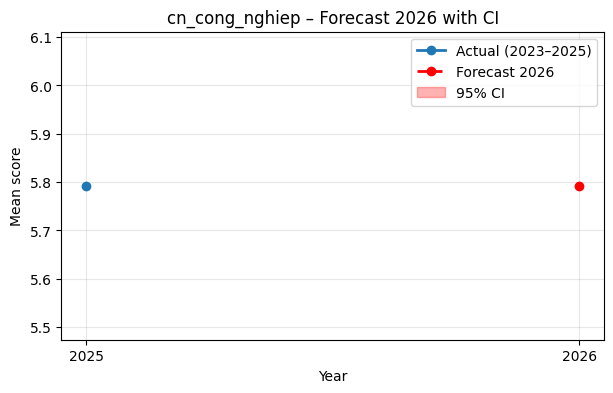

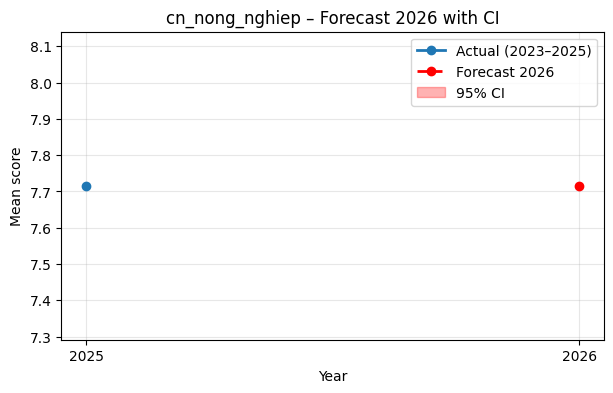

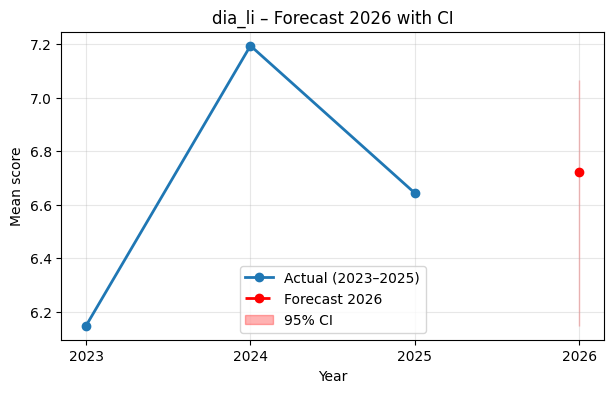

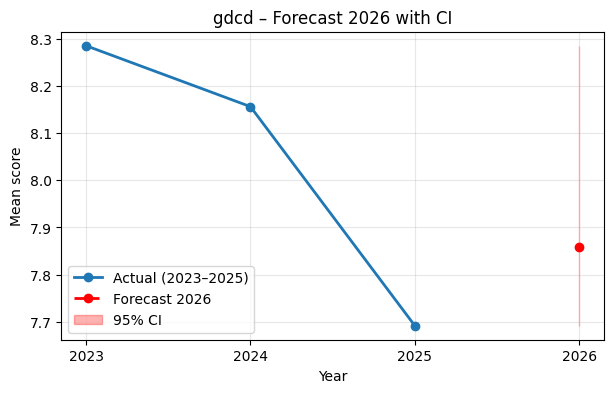

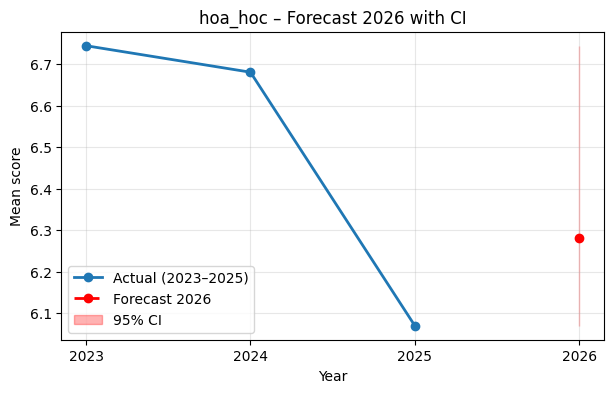

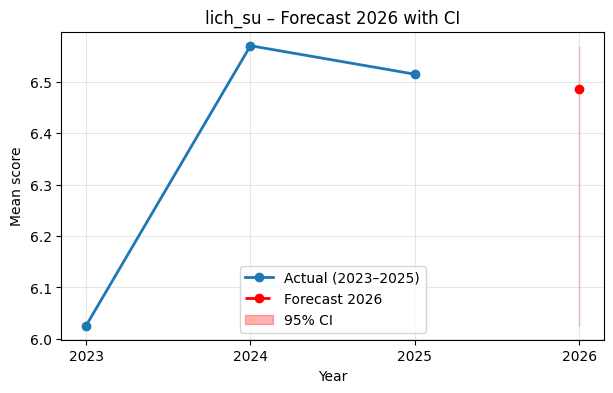

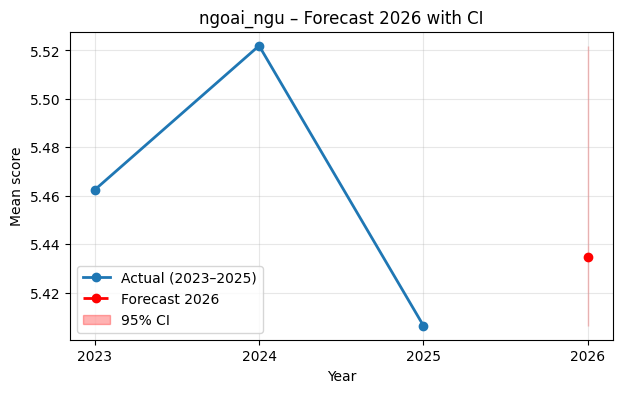

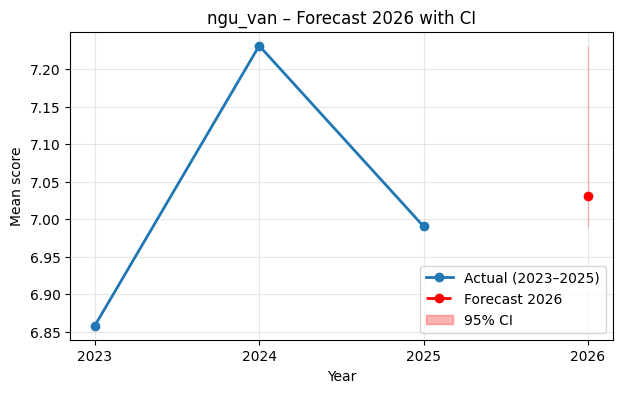

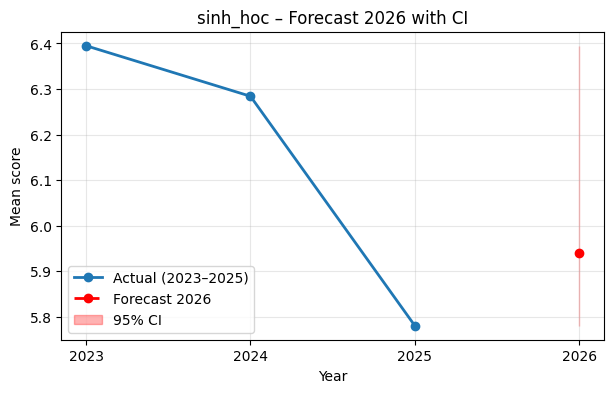

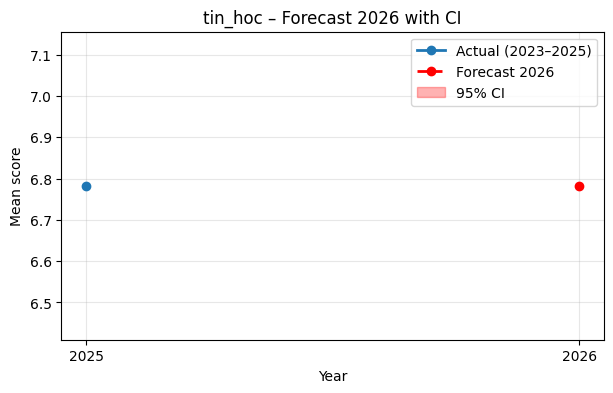

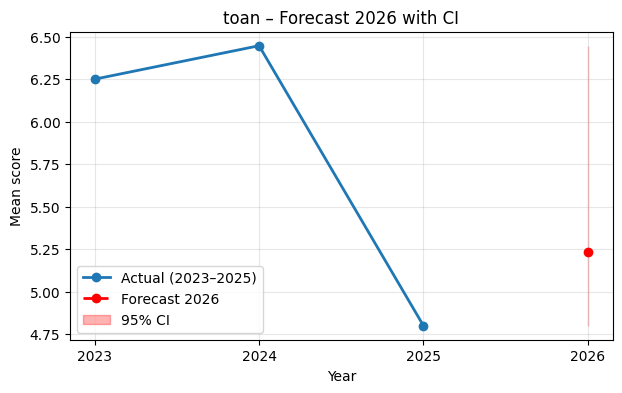

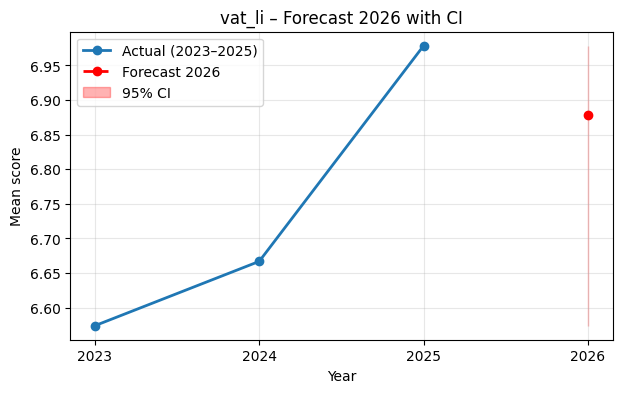

In [ ]:
for subj in subjects:
    df_subj = df_all_forecasts[df_all_forecasts["subject"] == subj]

    plt.figure(figsize=(7,4))

    # ----- Actual 2023–2025 -----
    df_actual = df_subj[df_subj["mean_actual"].notna()]
    plt.plot(
        df_actual["year"],
        df_actual["mean_actual"],
        marker='o',
        linewidth=2,
        label="Actual (2023–2025)"
    )

    # ----- Forecast 2026 -----
    df_fc = df_subj[df_subj["year"] == 2026]

    plt.plot(
        df_fc["year"],
        df_fc["mean_predicted"],
        marker='o',
        linestyle='--',
        color='red',
        linewidth=2,
        label="Forecast 2026"
    )

    # ----- CI (CHỈ cho 2026) -----
    if df_fc[["lower_CI", "upper_CI"]].notna().all(axis=None):
        plt.fill_between(
            df_fc["year"],
            df_fc["lower_CI"],
            df_fc["upper_CI"],
            color='red',
            alpha=0.3,
            label="95% CI"
        )

    plt.title(f"{subj} – Forecast 2026 with CI")
    plt.xlabel("Year")
    plt.ylabel("Mean score")
    plt.xticks(df_subj["year"].unique())
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


---

# Dự báo theo tỉ lệ tổ hợp

In [ ]:
import pandas as pd
from pathlib import Path
from Module.Load_Data import CleanDataLoader
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge  
from sklearn.metrics import mean_absolute_error, r2_score


def load_all_block_analysis_with_features(
    clean_data: CleanDataLoader,
) -> pd.DataFrame:
    """
    - Đọc toàn bộ Export_Analysis_<BLOCK>.csv và Export_Distribution_<BLOCK>.csv
      từ Block_Data để tạo bảng feature cho train.
    - Thêm:
        + n_students: số thí sinh của khối đó trong từng năm (từ distribution)
        + total_students_year: tổng số thí sinh toàn năm (từ clean_data.get_total_students())
      (KHÔNG tính share_in_year ở đây, sẽ tính sau khi gộp khoi_group)
    """

    block_root: Path = clean_data.block_data_root
    if not block_root.exists():
        raise FileNotFoundError(f"Block_Data folder không tồn tại: {block_root}")

    all_dfs = []

    # Tiền tố folder: CleanData_<BLOCK> (ví dụ CleanData_A00)
    folder_prefix = clean_data._block_data_f_prefix + "_"   # "CleanData_"

    for sub in block_root.iterdir():
        if not sub.is_dir():
            continue

        folder_name = sub.name
        if not folder_name.startswith(folder_prefix):
            continue

        # Lấy mã khối: CleanData_A00 -> A00
        block_code = folder_name[len(folder_prefix):]

        # 1) Đọc file analysis
        try:
            df_anal = clean_data.get_block_data(block=block_code, kind="analysis").copy()
        except FileNotFoundError:
            continue

        if "khoi" not in df_anal.columns:
            df_anal["khoi"] = block_code

        # 2) Đọc file distribution để đếm n_students theo năm
        try:
            df_dist = clean_data.get_block_data(block=block_code, kind="distribution").copy()
        except FileNotFoundError:
            df_dist = pd.DataFrame(columns=["nam_hoc", "so_hoc_sinh"])

        if not df_dist.empty:
            # Xác định cột đếm số học sinh
            if "so_hoc_sinh" in df_dist.columns:
                cnt_col = "so_hoc_sinh"
                counts = (
                    df_dist.groupby("nam_hoc")[cnt_col]
                           .sum()
                           .reset_index(name="n_students")
                )
            elif "count" in df_dist.columns:
                cnt_col = "count"
                counts = (
                    df_dist.groupby("nam_hoc")[cnt_col]
                           .sum()
                           .reset_index(name="n_students")
                )
            else:
                # fallback: chỉ đếm số dòng theo năm
                counts = (
                    df_dist.groupby("nam_hoc")
                           .size()
                           .reset_index(name="n_students")
                )
        else:
            counts = pd.DataFrame(columns=["nam_hoc", "n_students"])

        # 3) Merge n_students vào analysis
        df_merged = df_anal.merge(counts, on="nam_hoc", how="left")
        all_dfs.append(df_merged)

    if not all_dfs:
        return pd.DataFrame()

    block_analysis_all = pd.concat(all_dfs, ignore_index=True)

    # --- 4. Lấy tổng số thí sinh theo năm từ CleanDataLoader ---
    df_total = clean_data.get_total_students().copy()

    # Chuẩn hoá tên cột tổng số thí sinh về 'total_students_year'
    if "total_students_year" not in df_total.columns:
        for cand in ["tong_thi_sinh", "total_students", "so_thi_sinh",
                     "tong_hoc_sinh", "n_students"]:
            if cand in df_total.columns:
                df_total = df_total.rename(columns={cand: "total_students_year"})
                break

    if "nam_hoc" not in df_total.columns:
        raise ValueError(
            "DataFrame từ get_total_students() phải có cột 'nam_hoc'."
        )

    # Merge tổng thí sinh năm vào bảng feature
    block_analysis_all = block_analysis_all.merge(
        df_total[["nam_hoc", "total_students_year"]],
        on="nam_hoc",
        how="left"
    )

    # KHÔNG tính share_in_year ở đây nữa
    return block_analysis_all


In [ ]:
clean_data = CleanDataLoader(project_root=project_root_dir)

df_block_features = load_all_block_analysis_with_features(clean_data=clean_data)
df_block_features

,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year
0,2023,20.774499,21.150,22.10,3.094093,0.45,29.35,A00,325902,1017584
1,2024,20.904633,21.300,22.80,3.380354,2.15,29.60,A00,343800,1061604
2,2025,19.384368,19.250,22.00,4.337350,1.70,30.00,A00,165467,1153072
3,2023,20.275288,20.450,20.50,3.339521,5.05,29.80,A01,315146,1017584
4,2024,20.473793,20.750,21.00,3.350473,5.20,29.60,A01,329761,1061604
...,...,...,...,...,...,...,...,...,...,...
152,2025,20.486105,20.750,21.50,2.593046,8.95,26.50,Y07,475,1153072
153,2025,19.659654,19.900,21.00,2.518257,13.25,25.25,Y08,260,1153072
154,2025,21.366093,21.750,22.75,2.741671,7.25,28.50,Y09,9493,1153072
155,2025,17.617708,16.925,16.60,2.435760,13.95,24.00,Y10,48,1153072


# Xử lý dữ liệu trước khi Train

In [ ]:
import numpy as np
import pandas as pd

# 1) Chọn 10 khối muốn mô hình hóa
TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01",
              "D07", "D08", "D09", "A02", "A03"]  # chỉnh lại nếu muốn

# 2) Lọc ra data chỉ chứa 10 khối này
df_top = df_block_features[df_block_features["khoi"].isin(TOP_BLOCKS)].copy()

# Ép kiểu numeric cơ bản
df_top["nam_hoc"] = pd.to_numeric(df_top["nam_hoc"], errors="coerce")
df_top = df_top.dropna(subset=["nam_hoc"]).copy()
df_top["nam_hoc"] = df_top["nam_hoc"].astype(int)

for col in ["mean", "median", "mode", "std", "min", "max", "n_students", "total_students_year"]:
    if col in df_top.columns:
        df_top[col] = pd.to_numeric(df_top[col], errors="coerce")

# 3) Tính share_in_year TRONG 10 KHỐI:
df_top["share_in_year"] = df_top["n_students"] / df_top["total_students_year"]

# (Optional) normalize lần nữa cho chắc
df_top["share_in_year"] = df_top["share_in_year"] / (
    df_top.groupby("nam_hoc")["share_in_year"].transform("sum") + 1e-12
)

print("Years:", sorted(df_top["nam_hoc"].unique()))
print("Blocks:", sorted(df_top["khoi"].unique()))
print("Sum share per year (should ≈1):")
print(df_top.groupby("nam_hoc")["share_in_year"].sum().sort_index())

df_top


Years: [np.int64(2023), np.int64(2024), np.int64(2025)]
Blocks: ['A00', 'A01', 'A02', 'A03', 'B00', 'C00', 'D01', 'D07', 'D08', 'D09']
Sum share per year (should ≈1):
nam_hoc
2023    1.0
2024    1.0
2025    1.0
Name: share_in_year, dtype: float64


,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year,share_in_year
0,2023,20.774499,21.15,22.10,3.094093,0.45,29.35,A00,325902,1017584,0.070797
1,2024,20.904633,21.30,22.80,3.380354,2.15,29.60,A00,343800,1061604,0.071852
2,2025,19.384368,19.25,22.00,4.337350,1.70,30.00,A00,165467,1153072,0.110738
3,2023,20.275288,20.45,20.50,3.339521,5.05,29.80,A01,315146,1017584,0.068460
4,2024,20.473793,20.75,21.00,3.350473,5.20,29.60,A01,329761,1061604,0.068918
5,2025,18.878852,18.85,20.00,3.627548,5.50,29.75,A01,148930,1153072,0.099671
6,2023,20.426486,20.70,21.75,2.725684,6.00,28.80,A02,322538,1017584,0.070066
7,2024,20.510198,20.90,22.00,2.861235,3.95,28.95,A02,339801,1061604,0.071016
8,2025,15.815566,15.50,14.60,3.340573,5.95,27.25,A02,5708,1153072,0.003820
9,2025,16.070219,16.00,16.35,3.031460,5.60,29.00,A03,16895,1153072,0.011307


In [ ]:
# 4) year_idx theo thời gian
df_top["year_idx"] = df_top["nam_hoc"] - df_top["nam_hoc"].min()

# 5) sort theo (khoi, năm)
df_top = df_top.sort_values(["khoi", "nam_hoc"]).reset_index(drop=True)

# 6) Tính lag & delta share theo từng khối
df_top["share_lag1"]  = df_top.groupby("khoi")["share_in_year"].shift(1)
df_top["delta_share"] = df_top["share_in_year"] - df_top["share_lag1"]

# 7) Bỏ năm đầu (không có lag)
df_model_top = df_top.dropna(subset=["share_lag1"]).copy()

# 8) Chọn bộ feature dùng chung cho train
base_features_top = [
    "year_idx",
    "mean", "median", "std",
    "n_students", "total_students_year",
    "share_lag1", "delta_share",
]

print("df_model_top shape:", df_model_top.shape)
print("Years in df_model_top:", sorted(df_model_top["nam_hoc"].unique()))
print("Rows per year:")
print(df_model_top.groupby("nam_hoc")["khoi"].nunique().sort_index())

df_model_top

df_model_top shape: (18, 14)
Years in df_model_top: [np.int64(2024), np.int64(2025)]
Rows per year:
nam_hoc
2024    9
2025    9
Name: khoi, dtype: int64


,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year,share_in_year,year_idx,share_lag1,delta_share
1,2024,20.904633,21.30,22.80,3.380354,2.15,29.60,A00,343800,1061604,0.071852,1,0.070797,0.001055
2,2025,19.384368,19.25,22.00,4.337350,1.70,30.00,A00,165467,1153072,0.110738,2,0.071852,0.038886
4,2024,20.473793,20.75,21.00,3.350473,5.20,29.60,A01,329761,1061604,0.068918,1,0.068460,0.000458
5,2025,18.878852,18.85,20.00,3.627548,5.50,29.75,A01,148930,1153072,0.099671,2,0.068918,0.030753
7,2024,20.510198,20.90,22.00,2.861235,3.95,28.95,A02,339801,1061604,0.071016,1,0.070066,0.000950
8,2025,15.815566,15.50,14.60,3.340573,5.95,27.25,A02,5708,1153072,0.003820,2,0.071016,-0.067196
11,2024,20.531107,20.75,21.20,2.981836,3.20,29.55,B00,342291,1061604,0.071537,1,0.070504,0.001033
12,2025,18.340640,18.10,22.75,4.501786,3.20,30.00,B00,46607,1153072,0.031191,2,0.071537,-0.040345
14,2024,20.952817,21.25,21.25,3.465673,0.00,29.75,C00,704008,1061604,0.147133,1,0.148093,-0.000960
15,2025,19.712084,19.85,23.25,4.291575,0.50,29.75,C00,310012,1153072,0.207474,2,0.147133,0.060341


# Các mô hình dự báo

- Linear Regression

In [ ]:
import numpy as np
# Linear Regression với Gradient Descent
class LinearRegressionGD:
    def __init__(
        self,
        lr: float = 0.01,
        n_iter: int = 2000,
        reg_lambda: float = 0.0,
        verbose: bool = False,
        random_state: int | None = None,
    ):
        """
        Linear Regression (OLS) huấn luyện bằng Gradient Descent.

        lr         : learning rate
        n_iter     : số vòng lặp GD
        reg_lambda : hệ số L2 regularization (0 = không regularize)
        """
        self.lr = lr
        self.n_iter = n_iter
        self.reg_lambda = reg_lambda
        self.verbose = verbose
        self.random_state = random_state

        self.W = None   # (d,)
        self.b = None   # scalar

    # Huấn luyện model với dữ liệu X, y
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)

        # Kích thước dữ liệu
        N, d = X.shape

        # Khởi tạo tham số
        rng = np.random.default_rng(self.random_state)
        self.W = rng.normal(loc=0.0, scale=0.01, size=d)
        self.b = 0.0

        # Thực hiện tìm Gradient Descent
        for it in range(self.n_iter):
            # y_hat = XW + b: Dự đoán
            y_hat = X @ self.W + self.b  # (N,)

            # residuals: đo sai số giữa dự đoán và thực tế ( Tính mất mát )
            err = y_hat - y             # (N,)

            # gradient (MSE + L2): 
            dW = (X.T @ err) / N + self.reg_lambda * self.W   # (d,)
            db = err.mean()                                   # scalar

            # update: Cập nhật tham số
            self.W -= self.lr * dW
            self.b -= self.lr * db

            # Kiểm tra loss mỗi 200 vòng hoặc vòng cuối
            if self.verbose and (it % 200 == 0 or it == self.n_iter - 1):
                mse = (err ** 2).mean()
                loss = mse + 0.5 * self.reg_lambda * np.sum(self.W ** 2)
                # print(f"Iter {it:4d} | loss = {loss:.8f}")

        return self

    # Dự đoán với dữ liệu X mới
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.W is None:
            raise ValueError("Model chưa được fit.")
        X = np.asarray(X, dtype=float)
        return X @ self.W + self.b


- Multi Share

In [ ]:
class MultiShareRegressor:
    """
    Regression model dự đoán share_in_year.
    - X = base_features + one-hot khoi_group
    - y = share_in_year
    - Predict theo năm: clip >=0 + normalize tổng = 1
    Workflow:
      fit(df_model) -> evaluate(df_model, year) -> forecast(df, next_year)
    """
    def __init__(self, base_features, alpha=1.0, random_state=42, normalize_method="softmax", temperature=2.0):
        self.base_features = list(base_features)
        self.alpha = float(alpha)
        self.random_state = random_state
        self.normalize_method = normalize_method  # "softmax" or "shift"
        self.temperature = float(temperature)

        self.model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=self.alpha, random_state=self.random_state))
        ])

        self.dummy_cols_ = None
        self._fitted = False

    @staticmethod
    def _softmax(v, temp=1.0):
        v = np.asarray(v, dtype=float)
        z = (v - np.max(v)) / max(temp, 1e-9)
        e = np.exp(z)
        return e / (e.sum() + 1e-12)

    @staticmethod
    def _shift_norm(v):
        v = np.asarray(v, dtype=float)
        v = v - np.min(v) + 1e-9
        return v / (v.sum() + 1e-12)

    def _clean(self, df):
        out = df.copy()
        out["nam_hoc"] = pd.to_numeric(out["nam_hoc"], errors="coerce")
        out = out.dropna(subset=["nam_hoc", "khoi_group", "share_in_year"])
        out["nam_hoc"] = out["nam_hoc"].astype(int)
        out["khoi_group"] = out["khoi_group"].astype(str)

        for c in self.base_features + ["share_in_year"]:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce")
        out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=self.base_features + ["share_in_year"])
        return out

    def _build_X(self, df):
        dummies = pd.get_dummies(df["khoi_group"], prefix="khoi_group")

        # lúc fit: lưu danh sách cột dummy chuẩn
        if self.dummy_cols_ is None:
            self.dummy_cols_ = list(dummies.columns)

        # lúc predict: align cột dummy
        for col in self.dummy_cols_:
            if col not in dummies.columns:
                dummies[col] = 0
        dummies = dummies[self.dummy_cols_]

        X = pd.concat([df[self.base_features].reset_index(drop=True), dummies.reset_index(drop=True)], axis=1)
        return X

    def fit(self, df_train, weight_col="n_students"):
        df_train = self._clean(df_train)

        X = self._build_X(df_train).values
        y = df_train["share_in_year"].values.astype(float)

        # sample_weight theo quy mô (optional)
        if weight_col in df_train.columns:
            w = pd.to_numeric(df_train[weight_col], errors="coerce").fillna(1.0).values.astype(float)
        else:
            w = None

        if w is None:
            self.model.fit(X, y)
        else:
            self.model.fit(X, y, ridge__sample_weight=w)

        self._fitted = True
        return self

    def predict_raw(self, df_any):
        if not self._fitted:
            raise RuntimeError("Model chưa fit().")
        df_any = self._clean(df_any)
        X = self._build_X(df_any).values
        y_raw = self.model.predict(X).astype(float)
        return df_any, y_raw

    def predict_share_year(self, df_year):
        df_year, y_raw = self.predict_raw(df_year)

        if self.normalize_method == "softmax":
            share = self._softmax(y_raw, temp=self.temperature)
        else:
            share = self._shift_norm(y_raw)

        out = pd.DataFrame({
            "khoi_group": df_year["khoi_group"].values,
            "share_pred": share
        })

        # đảm bảo tổng = 1
        out["share_pred"] = out["share_pred"] / (out["share_pred"].sum() + 1e-12)
        return out

    def evaluate_year(self, df_all, year):
        df_all = self._clean(df_all)
        year = int(year)

        df_year = df_all[df_all["nam_hoc"] == year].copy()

        df_true = df_year[["khoi_group","share_in_year"]].copy()
        df_true = df_true.groupby("khoi_group", as_index=False)["share_in_year"].sum()
        df_true = df_true.rename(columns={"share_in_year":"share_true"})
        df_true["share_true"] = df_true["share_true"] / (df_true["share_true"].sum() + 1e-12)

        df_pred = self.predict_share_year(df_year[["nam_hoc","khoi_group","share_in_year"] + self.base_features])

        df_eval = df_true.merge(df_pred, on="khoi_group", how="outer").fillna(0)
        df_eval["abs_err"] = (df_eval["share_true"] - df_eval["share_pred"]).abs()

        mae = float(df_eval["abs_err"].mean())
        return df_eval.sort_values("abs_err", ascending=False).reset_index(drop=True), mae

    def build_features_for_next_year(self, df_all):
        """
        Tạo df_next (năm max+1) theo logic:
          - year_idx tăng 1
          - share_lag1 = share_in_year năm cuối
          - delta_share = share_in_year(last) - share_in_year(last-1)
          - các stats khác copy từ năm cuối (mean/median/std/n_students/total_students_year)
        """
        df_all = self._clean(df_all)
        last_year = int(df_all["nam_hoc"].max())
        prev_year = last_year - 1

        df_last = df_all[df_all["nam_hoc"] == last_year].copy()
        df_prev = df_all[df_all["nam_hoc"] == prev_year][["khoi_group","share_in_year"]].copy()
        df_prev = df_prev.rename(columns={"share_in_year":"share_prev"})

        df_next = df_last.merge(df_prev, on="khoi_group", how="left")
        df_next["share_lag1"] = df_next["share_in_year"]
        df_next["delta_share"] = df_next["share_in_year"] - df_next["share_prev"].fillna(df_next["share_in_year"])
        df_next["year_idx"] = int(df_last["year_idx"].max()) + 1
        df_next["nam_hoc"] = last_year + 1

        # đảm bảo đủ base_features
        for c in self.base_features:
            if c not in df_next.columns:
                df_next[c] = 0

        return df_next[["nam_hoc","khoi_group","share_in_year"] + self.base_features].copy()

    def forecast_next_year(self, df_all):
        df_next = self.build_features_for_next_year(df_all)
        return self.predict_share_year(df_next)


- ARIMA Forecast

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA forecast cho share theo từng khoi_group
class ArimaShareModel:
    """
    ARIMA forecast cho share theo từng khoi_group.
    - Fix warning bằng PeriodIndex(freq="Y")
    - Forecast từng group, clip >= 1e-9
    - Normalize tổng share = 1
    """
    def __init__(self, min_points_for_ar1=4):
        self.min_points_for_ar1 = min_points_for_ar1

    @staticmethod
    def _to_series(sub_df):
        years = sub_df["nam_hoc"].astype(int).tolist()
        vals = pd.to_numeric(sub_df["share_in_year"], errors="coerce").astype(float).tolist()
        s = pd.Series(vals, index=pd.PeriodIndex(years, freq="Y")).asfreq("Y")
        return s

    def _forecast_one(self, s: pd.Series):
        s = s.astype(float)
        if len(s) < 2:
            return float(s.iloc[-1])
        order = (1,0,0) if len(s) >= self.min_points_for_ar1 else (0,0,0)
        try:
            res = ARIMA(s, order=order).fit()
            return float(res.forecast(steps=1).iloc[0])
        except Exception:
            return float(s.iloc[-1])

    def forecast_year(self, df_all, target_year):
        df_all = df_all.copy()
        df_all["nam_hoc"] = df_all["nam_hoc"].astype(int)
        df_all["khoi_group"] = df_all["khoi_group"].astype(str)
        df_all["share_in_year"] = pd.to_numeric(df_all["share_in_year"], errors="coerce")
        df_all = df_all.dropna(subset=["share_in_year"])

        preds = {}
        for g, sub in df_all.groupby("khoi_group"):
            sub = sub.sort_values("nam_hoc")
            sub = sub[sub["nam_hoc"] < int(target_year)]
            if len(sub) == 0:
                continue
            s = self._to_series(sub)
            yhat = self._forecast_one(s)
            preds[g] = max(yhat, 1e-9)

        pred = pd.Series(preds, name=f"share_pred_{int(target_year)}")
        pred = pred / pred.sum()
        return pred.reset_index().rename(columns={"index": "khoi_group"})

    def evaluate_year(self, df_all, year):
        year = int(year)
        df_all = df_all.copy()
        df_all["nam_hoc"] = df_all["nam_hoc"].astype(int)

        df_true = df_all[df_all["nam_hoc"] == year][["khoi_group", "share_in_year"]].copy()
        df_true = df_true.groupby("khoi_group", as_index=False)["share_in_year"].mean()
        df_true = df_true.rename(columns={"share_in_year": "share_true"})

        df_pred = self.forecast_year(df_all, target_year=year)
        pred_col = f"share_pred_{year}"

        df_eval = df_true.merge(df_pred, on="khoi_group", how="outer").fillna(0)
        df_eval["abs_err"] = (df_eval["share_true"] - df_eval[pred_col]).abs()
        mae = df_eval["abs_err"].mean()
        return df_eval.sort_values("abs_err", ascending=False).reset_index(drop=True), mae


# Train mô hình và dự báo

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# ----- Năm test -----
YEAR_TEST = int(df_top["nam_hoc"].max())  # hiện tại là 2025

# ----- Tách train / test từ df_model_top -----
train_mask_top = df_model_top["nam_hoc"] < YEAR_TEST   # 2023–2024
test_mask_top  = df_model_top["nam_hoc"] == YEAR_TEST  # 2025

train_df_top = df_model_top.loc[train_mask_top].copy()
test_df_top  = df_model_top.loc[test_mask_top].copy()

# X = base_features_top + one-hot khoi
X_train_df = pd.concat(
    [train_df_top[base_features_top],
     pd.get_dummies(train_df_top["khoi"], prefix="khoi")],
    axis=1
)
X_test_df = pd.concat(
    [test_df_top[base_features_top],
     pd.get_dummies(test_df_top["khoi"], prefix="khoi")],
    axis=1
)

# Align cột one-hot giữa train/test
X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)

X_train = X_train_df.values
y_train = train_df_top["share_in_year"].values.astype(float)
X_test  = X_test_df.values
y_test  = test_df_top["share_in_year"].values.astype(float)

# ----- Scale feature -----
scaler_lin_top = StandardScaler()
X_train_s = scaler_lin_top.fit_transform(X_train)
X_test_s  = scaler_lin_top.transform(X_test)

# ----- Train LinearRegressionGD -----
lin_model_top = LinearRegressionGD(
    lr=1e-4,
    n_iter=30000,
    reg_lambda=5e-2,
    verbose=False,
    random_state=42,
)
lin_model_top.fit(X_train_s, y_train)

# ----- Softmax để ra phân phối share (10 khối tổng = 1) -----
def softmax(v, temp=2.0):
    v = np.asarray(v, dtype=float)
    z = (v - np.max(v)) / max(temp, 1e-9)
    e = np.exp(z)
    return e / (e.sum() + 1e-12)

y_raw_lin = lin_model_top.predict(X_test_s)
y_pred_lin = softmax(y_raw_lin, temp=2.0)

# ----- Đánh giá -----
df_eval_lin_top = test_df_top[["khoi"]].copy()
df_eval_lin_top["share_true"] = y_test
df_eval_lin_top["share_pred"] = y_pred_lin
df_eval_lin_top["abs_err"] = (df_eval_lin_top["share_true"] - df_eval_lin_top["share_pred"]).abs()

mae_lin_top = df_eval_lin_top["abs_err"].mean()
print(f"[Linear-GD 10 blocks] MAE ({YEAR_TEST}) = {mae_lin_top:.4f}")
print(df_eval_lin_top.sort_values("khoi").reset_index(drop=True))


[Linear-GD 10 blocks] MAE (2025) = 0.1092
  khoi  share_true  share_pred   abs_err
0  A00    0.110738    0.085351  0.025386
1  A01    0.099671    0.087910  0.011761
2  A02    0.003820    0.150924  0.147104
3  B00    0.031191    0.131833  0.100642
4  C00    0.207474    0.078069  0.129405
5  D01    0.241094    0.082190  0.158904
6  D07    0.242571    0.082234  0.160337
7  D08    0.003149    0.148846  0.145697
8  D09    0.048985    0.152643  0.103658


In [ ]:
# ----- Năm test -----
YEAR_TEST = int(df_top["nam_hoc"].max())  # 2025

# Đổi tên 'khoi' -> 'khoi_group' để dùng lại MultiShareRegressor
df_model_top_multi = df_model_top.rename(columns={"khoi": "khoi_group"}).copy()

# Train set: tất cả năm < YEAR_TEST
train_df_multi = df_model_top_multi[df_model_top_multi["nam_hoc"] < YEAR_TEST].copy()

multi_reg_top = MultiShareRegressor(
    base_features=base_features_top,
    alpha=1.0,              # có thể tune 0.1 / 1 / 10
    random_state=42,
    normalize_method="softmax",
    temperature=2.0,
)

# ----- Fit -----
multi_reg_top.fit(train_df_multi)

# ----- Evaluate trên YEAR_TEST (2025) -----
eval_multi_top_2025, mae_multi_top_2025 = multi_reg_top.evaluate_year(
    df_model_top_multi, YEAR_TEST
)

print(f"[Multi-REG 10 blocks] MAE ({YEAR_TEST}) = {mae_multi_top_2025:.4f}")
print(eval_multi_top_2025.sort_values("khoi_group").reset_index(drop=True))


[Multi-REG 10 blocks] MAE (2025) = 0.0994
  khoi_group  share_true  share_pred   abs_err
0        A00    0.112004    0.093835  0.018169
1        A01    0.100810    0.095936  0.004874
2        A02    0.003864    0.136779  0.132915
3        B00    0.031548    0.124544  0.092996
4        C00    0.209846    0.088968  0.120878
5        D01    0.243851    0.092935  0.150916
6        D07    0.245345    0.092846  0.152499
7        D08    0.003185    0.135408  0.132223
8        D09    0.049546    0.138748  0.089203


In [ ]:
# ----- Năm test -----
YEAR_TEST = int(df_top["nam_hoc"].max())  # 2025

# Đổi tên 'khoi' -> 'khoi_group' để dùng lại ArimaShareModel
df_top_arima = df_top.rename(columns={"khoi": "khoi_group"}).copy()

arima_top = ArimaShareModel(min_points_for_ar1=4)

# ----- Evaluate YEAR_TEST: dùng data < YEAR_TEST để forecast YEAR_TEST -----
eval_arima_top_2025, mae_arima_top_2025 = arima_top.evaluate_year(
    df_top_arima, YEAR_TEST
)

print(f"[ARIMA 10 blocks] MAE ({YEAR_TEST}) = {mae_arima_top_2025:.4f}")
print(eval_arima_top_2025.sort_values("khoi_group").reset_index(drop=True))


[ARIMA 10 blocks] MAE (2025) = 0.0488
  khoi_group  share_true  share_pred_2025   abs_err
0        A00    0.110738         0.071323  0.039415
1        A01    0.099671         0.068688  0.030982
2        A02    0.003820         0.070540  0.066720
3        A03    0.011307         0.000000  0.011307
4        B00    0.031191         0.071019  0.039827
5        C00    0.207474         0.147614  0.059859
6        D01    0.241094         0.190342  0.050752
7        D07    0.242571         0.190932  0.051639
8        D08    0.003149         0.068341  0.065192
9        D09    0.048985         0.121201  0.072216


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
